## Predict Loan Defaulters

This project was built as a part of the Deloitte machine learning challenge: Predict Loan Defaulters. This solution achieved the 2(nd) place in the competition.

The main goal of this competition is to predict if a person will be a loan defaulter or not. With the purpose to solve this problem, Deloitte in association with MachineHack made available a train dataset conatining 34 explanatory variables and one target variable (Loan Status).The challenge consists in a classification problem with imbalaced classes.

In this circumstances, as all the people would have less than 50% of probability to be a defaulter, any model would predict only 0s. Metrics like accuracy score, precision, f1 score, recall and AUC wouldn't be effective for this problem. Because of this, the organizers chose a metric based on the probability of a person to be a defaulter or not. The metric chosen was the Log Loss metric.

In [ ]:
#1 Import the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [ ]:
#Loading the train dataset
df=pd.read_csv('train.csv')
df.head()

,ID,Loan Amount,Funded Amount,Funded Amount Investor,Term,Batch Enrolled,Interest Rate,Grade,Sub Grade,Employment Duration,Home Ownership,Verification Status,Payment Plan,Loan Title,Debit to Income,Delinquency - two years,Inquires - six months,Open Account,Public Record,Revolving Balance,Revolving Utilities,Total Accounts,Initial List Status,Total Received Interest,Total Received Late Fee,Recoveries,Collection Recovery Fee,Collection 12 months Medical,Application Type,Last week Pay,Accounts Delinquent,Total Collection Amount,Total Current Balance,Total Revolving Credit Limit,Loan Status
0,65087372,10000,32236,12329.36286,59,BAT2522922,11.135007,B,C4,MORTGAGE,176346.62670,Not Verified,n,Debt Consolidation,16.284758,1,0,13,0,24246,74.932551,7,w,2929.646315,0.102055,2.498291,0.793724,0,INDIVIDUAL,49,0,31,311301,6619,0
1,1450153,3609,11940,12191.99692,59,BAT1586599,12.237563,C,D3,RENT,39833.92100,Source Verified,n,Debt consolidation,15.412409,0,0,12,0,812,78.297186,13,f,772.769385,0.036181,2.377215,0.974821,0,INDIVIDUAL,109,0,53,182610,20885,0
2,1969101,28276,9311,21603.22455,59,BAT2136391,12.545884,F,D4,MORTGAGE,91506.69105,Source Verified,n,Debt Consolidation,28.137619,0,0,14,0,1843,2.073040,20,w,863.324396,18.778660,4.316277,1.020075,0,INDIVIDUAL,66,0,34,89801,26155,0
3,6651430,11170,6954,17877.15585,59,BAT2428731,16.731201,C,C3,MORTGAGE,108286.57590,Source Verified,n,Debt consolidation,18.043730,1,0,7,0,13819,67.467951,12,w,288.173196,0.044131,0.107020,0.749971,0,INDIVIDUAL,39,0,40,9189,60214,0
4,14354669,16890,13226,13539.92667,59,BAT5341619,15.008300,C,D4,MORTGAGE,44234.82545,Source Verified,n,Credit card refinancing,17.209886,1,3,13,1,1544,85.250761,22,w,129.239553,19.306646,1294.818751,0.368953,0,INDIVIDUAL,18,0,430,126029,22579,0


In [ ]:
#Loading the test dataset
test=pd.read_csv('test.csv')
test.head()

,ID,Loan Amount,Funded Amount,Funded Amount Investor,Term,Batch Enrolled,Interest Rate,Grade,Sub Grade,Employment Duration,Home Ownership,Verification Status,Payment Plan,Loan Title,Debit to Income,Delinquency - two years,Inquires - six months,Open Account,Public Record,Revolving Balance,Revolving Utilities,Total Accounts,Initial List Status,Total Received Interest,Total Received Late Fee,Recoveries,Collection Recovery Fee,Collection 12 months Medical,Application Type,Last week Pay,Accounts Delinquent,Total Collection Amount,Total Current Balance,Total Revolving Credit Limit,Loan Status
0,56492997,17120,10365,16025.082690,59,BAT2575549,12.163926,A,D1,RENT,76468.82190,Source Verified,n,Home improvement,16.749219,1,0,12,1,3576,67.278287,5,f,4469.449851,0.088031,8.425776,0.731797,0,INDIVIDUAL,135,0,24,475442,4364,NaN
1,22540813,7133,11650,12615.795600,59,BAT2833642,6.564296,B,E3,MORTGAGE,38079.01344,Source Verified,n,Credit card refinancing,18.157975,0,0,11,0,1932,71.313157,21,w,993.907530,0.041237,6.157008,0.992918,0,INDIVIDUAL,56,0,1,72412,2573,NaN
2,9862181,25291,25825,11621.280830,59,BAT1761981,14.729900,A,C3,MORTGAGE,51275.93268,Source Verified,n,Debt consolidation,15.190011,0,0,22,0,598,50.883065,23,f,729.113379,0.021745,5.705077,0.281580,0,INDIVIDUAL,3,0,26,284825,19676,NaN
3,10097822,30781,9664,15375.823510,59,BAT5341619,10.523767,A,A2,RENT,68867.98965,Verified,n,Debt Consolidation,21.292550,0,0,11,0,5222,82.449083,28,w,715.867091,0.092398,2.469688,0.959162,0,INDIVIDUAL,21,0,32,40842,7226,NaN
4,47771809,8878,9419,7176.647582,58,BAT4694572,9.997013,C,B3,OWN,91556.85423,Verified,n,Debt consolidation,4.812117,0,0,11,0,553,49.075855,9,w,248.572854,0.010354,2.127835,0.402315,0,INDIVIDUAL,104,0,33,90825,26145,NaN


In [ ]:
# Analyzing the features. As we can see, there are no missing values on the train  and test datasets. 

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67463 entries, 0 to 67462
Data columns (total 35 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   ID                            67463 non-null  int64  
 1   Loan Amount                   67463 non-null  int64  
 2   Funded Amount                 67463 non-null  int64  
 3   Funded Amount Investor        67463 non-null  float64
 4   Term                          67463 non-null  int64  
 5   Batch Enrolled                67463 non-null  object 
 6   Interest Rate                 67463 non-null  float64
 7   Grade                         67463 non-null  object 
 8   Sub Grade                     67463 non-null  object 
 9   Employment Duration           67463 non-null  object 
 10  Home Ownership                67463 non-null  float64
 11  Verification Status           67463 non-null  object 
 12  Payment Plan                  67463 non-null  object 
 13  L

In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28913 entries, 0 to 28912
Data columns (total 35 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   ID                            28913 non-null  int64  
 1   Loan Amount                   28913 non-null  int64  
 2   Funded Amount                 28913 non-null  int64  
 3   Funded Amount Investor        28913 non-null  float64
 4   Term                          28913 non-null  int64  
 5   Batch Enrolled                28913 non-null  object 
 6   Interest Rate                 28913 non-null  float64
 7   Grade                         28913 non-null  object 
 8   Sub Grade                     28913 non-null  object 
 9   Employment Duration           28913 non-null  object 
 10  Home Ownership                28913 non-null  float64
 11  Verification Status           28913 non-null  object 
 12  Payment Plan                  28913 non-null  object 
 13  L

In [ ]:
# Showing de descriptive statistics
df.describe()

,ID,Loan Amount,Funded Amount,Funded Amount Investor,Term,Interest Rate,Home Ownership,Debit to Income,Delinquency - two years,Inquires - six months,Open Account,Public Record,Revolving Balance,Revolving Utilities,Total Accounts,Total Received Interest,Total Received Late Fee,Recoveries,Collection Recovery Fee,Collection 12 months Medical,Last week Pay,Accounts Delinquent,Total Collection Amount,Total Current Balance,Total Revolving Credit Limit,Loan Status
count,6.746300e+04,67463.000000,67463.000000,67463.000000,67463.000000,67463.000000,67463.000000,67463.000000,67463.000000,67463.000000,67463.000000,67463.000000,67463.000000,67463.000000,67463.000000,67463.000000,67463.000000,67463.000000,67463.000000,67463.000000,67463.000000,67463.0,67463.000000,6.746300e+04,67463.000000,67463.000000
mean,2.562761e+07,16848.902776,15770.599114,14621.799323,58.173814,11.846258,80541.502522,23.299241,0.327127,0.145754,14.266561,0.081437,7699.342425,52.889443,18.627929,2068.992542,1.143969,59.691578,1.125141,0.021301,71.163260,0.0,146.467990,1.595739e+05,23123.005544,0.092510
std,2.109155e+07,8367.865726,8150.992662,6785.345170,3.327441,3.718629,45029.120366,8.451824,0.800888,0.473291,6.225060,0.346606,7836.148190,22.539450,8.319246,2221.918745,5.244365,357.026346,3.489885,0.144385,43.315845,0.0,744.382233,1.390332e+05,20916.699999,0.289747
min,1.297933e+06,1014.000000,1014.000000,1114.590204,36.000000,5.320006,14573.537170,0.675299,0.000000,0.000000,2.000000,0.000000,0.000000,0.005172,4.000000,4.736746,0.000003,0.000036,0.000036,0.000000,0.000000,0.0,1.000000,6.170000e+02,1000.000000,0.000000
25%,6.570288e+06,10012.000000,9266.500000,9831.684984,58.000000,9.297147,51689.843335,16.756416,0.000000,0.000000,10.000000,0.000000,2557.000000,38.658825,13.000000,570.903814,0.021114,1.629818,0.476259,0.000000,35.000000,0.0,24.000000,5.037900e+04,8155.500000,0.000000
50%,1.791565e+07,16073.000000,13042.000000,12793.682170,59.000000,11.377696,69335.832680,22.656658,0.000000,0.000000,13.000000,0.000000,5516.000000,54.082334,18.000000,1330.842771,0.043398,3.344524,0.780141,0.000000,68.000000,0.0,36.000000,1.183690e+05,16733.000000,0.000000
75%,4.271521e+07,22106.000000,21793.000000,17807.594120,59.000000,14.193533,94623.322785,30.048400,0.000000,0.000000,16.000000,0.000000,10184.500000,69.177117,23.000000,2656.956837,0.071884,5.453727,1.070566,0.000000,105.000000,0.0,46.000000,2.283750e+05,32146.500000,0.000000
max,7.224578e+07,35000.000000,34999.000000,34999.746430,59.000000,27.182348,406561.536400,39.629862,8.000000,5.000000,37.000000,4.000000,116933.000000,100.880050,72.000000,14301.368310,42.618882,4354.467419,166.833000,1.000000,161.000000,0.0,16421.000000,1.177412e+06,201169.000000,1.000000


In [ ]:
df.shape

(67463, 35)

##  EDA and Data Prepocessing

In [ ]:
# Let's look at the proportion of the target classes. 
df['Loan Status'].value_counts()

0    61222
1     6241
Name: Loan Status, dtype: int64

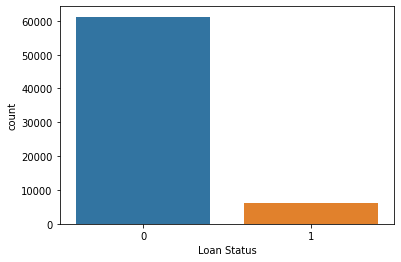

In [ ]:
# As we can see in the countplot below, the classes are imbalanced.
sns.countplot(df['Loan Status'])

Let's take a look at the features that bring no information to our problem. As we can see, there are 67463 different values for ID, the same quantity of rows we have in the train dataset. We are going to exclude the ID column.

In [ ]:

df['ID'].nunique()

67463

In [ ]:
df.drop('ID', axis=1, inplace=True)
test.drop('ID', axis=1, inplace=True)

Now we can see if we have duplicates.

In [ ]:
df.duplicated().sum(), test.duplicated().sum()

(0, 0)

We have already seen if the train and test dataset have missing values or duplicates. Now we are going to treat the categorical features, in a way that they can be used in our model.

In [ ]:
#These are the categorical features.
df.select_dtypes(include=['object']).columns

Index(['Batch Enrolled', 'Grade', 'Sub Grade', 'Employment Duration',
       'Verification Status', 'Payment Plan', 'Loan Title',
       'Initial List Status', 'Application Type'],
      dtype='object')

We have 9 categorical features to analyze. There are lots of possibilities to treat this features. We can quote: one hot encoding, label encoding, target encoding, we can exclude the feature if it's not an informative... 

As you are going to see, for most of the features I used ordinal encoding by calculating the percentage of defaulters for each class and ordering these. In other features I used the label encoder from SKLearn.

I tried to use the target encoding, but the model became overfitted, and the Log Loss metric for validation data got worse. One hot encoding also did not bring good results for the model.


Below we have the list of the categorical features:
 - Batch Enrolled
 - Grade
 - Sub Grade
 - Employment Duration
 - Verification Status
 - Payment Plan
 - Loan Title
 - Initial List Status
 - Application Type

  

* Batch Enrolled

In [ ]:
# We have 41 unique values.
df['Batch Enrolled'].nunique(), test['Batch Enrolled'].nunique()

(41, 41)

In [ ]:
#As we can assume in this cell and in the above, all the classes in train and test are the same.
df[df['Batch Enrolled'].isin(test['Batch Enrolled'].unique())]['Batch Enrolled'].nunique()

41

In [ ]:
# We are going to make a dataframe containing the % of defaulters for each batch. Note that this  kind of dataframe will be useful for other features.
count_Batch_Enrolled=df.groupby('Batch Enrolled').count().sort_values(by='Loan Status',ascending=False).reset_index()[['Batch Enrolled','Grade']]
sum_Batch_Enrolled=df.groupby('Batch Enrolled').sum().sort_values(by='Loan Status',ascending=False).reset_index()[['Batch Enrolled','Loan Status']]
countsum_Batch_Enrolled=pd.merge(count_Batch_Enrolled,sum_Batch_Enrolled, how='inner', on='Batch Enrolled')
countsum_Batch_Enrolled['Batch_Enrolled%']=countsum_Batch_Enrolled['Loan Status']/countsum_Batch_Enrolled['Grade']

In [ ]:
# The Batch_Enrolled% shows the % os defaulters for each batch.
countsum_Batch_Enrolled.head(10)[['Batch Enrolled', 'Batch_Enrolled%']]

,Batch Enrolled,Batch_Enrolled%
0,BAT3873588,0.093767
1,BAT1586599,0.105029
2,BAT1104812,0.099800
3,BAT2252229,0.093078
4,BAT2803411,0.088247
5,BAT1780517,0.099459
6,BAT1184694,0.083551
7,BAT2078974,0.091266
8,BAT2575549,0.094373
9,BAT4694572,0.096085


In [ ]:
# I'm using the describe function to take a look in the descriptive statistics. We can notice that the range of loan defaulters is from 7,8% to 12,5%.
#We are going to split the Batch Enrolled in 4 classes, 0 being the ones that have less probability to default and 4 the ones who have the most probability.
countsum_Batch_Enrolled['Batch_Enrolled%'].describe() 


count    41.000000
mean      0.092908
std       0.008739
min       0.078297
25%       0.086559
50%       0.093750
75%       0.096956
max       0.125000
Name: Batch_Enrolled%, dtype: float64

In [ ]:
countsum_Batch_Enrolled['Classe_Batch_Enrolled']=0
countsum_Batch_Enrolled.loc[countsum_Batch_Enrolled['Batch_Enrolled%']<0.08997275, 'Classe_Batch_Enrolled']=0
countsum_Batch_Enrolled.loc[(countsum_Batch_Enrolled['Batch_Enrolled%']>=0.08997275)&(countsum_Batch_Enrolled['Batch_Enrolled%']<0.1016485), 'Classe_Batch_Enrolled']=1
countsum_Batch_Enrolled.loc[(countsum_Batch_Enrolled['Batch_Enrolled%']>=0.1016485)&(countsum_Batch_Enrolled['Batch_Enrolled%']<0.11332425), 'Classe_Batch_Enrolled']=2
countsum_Batch_Enrolled.loc[countsum_Batch_Enrolled['Batch_Enrolled%']>=0.11332425, 'Classe_Batch_Enrolled']=3

In [ ]:
countsum_Batch_Enrolled=countsum_Batch_Enrolled[['Batch Enrolled', 'Classe_Batch_Enrolled']]

In [ ]:
#Let's merge the Countsum Batch_Enrolled with the df. Then we are going to exclude the original feature.

df=pd.merge(df, countsum_Batch_Enrolled, how='inner', on='Batch Enrolled')
test=pd.merge(test, countsum_Batch_Enrolled,  how='left', on='Batch Enrolled')

In [ ]:
# Droping the original feature.
df.drop('Batch Enrolled', axis=1, inplace=True)
test.drop('Batch Enrolled', axis=1, inplace=True)

In [ ]:
#Checking if the transformation worked.
test['Classe_Batch_Enrolled'].value_counts(), df['Classe_Batch_Enrolled'].value_counts()


(1    16952
 0     9765
 2     2091
 3      105
 Name: Classe_Batch_Enrolled, dtype: int64, 1    39806
 0    22483
 2     4878
 3      296
 Name: Classe_Batch_Enrolled, dtype: int64)

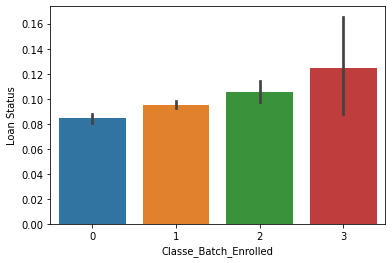

In [ ]:
# The barplot shows the mean and the standard deviation. As we can see, when the numer of the class get higher, the percentage os loan deafulters increase.
sns.barplot(x='Classe_Batch_Enrolled', y='Loan Status', data =df)

* Grade

In [ ]:
# We are going to do the same analysys that we did with Batch_Enrolled.

In [ ]:
count_grade=df.groupby('Grade').count().reset_index()[['Grade', 'Loan Amount']]
sum_grade=df.groupby('Grade').sum().reset_index()[['Grade', 'Loan Status']]
countsum_grade=pd.merge(count_grade,sum_grade, how='inner',on='Grade')
countsum_grade['gradepercent']=countsum_grade['Loan Status']/countsum_grade['Loan Amount']

In [ ]:
#We can clearly see that Grade is correlated with Loan Status, but is not that linear. This way, we are goig to split it in less classes. 
#Classe 0: A, B e C
#Classe 1: D, E
#Classe 2: F,G
countsum_grade[['Grade','gradepercent']]


,Grade,gradepercent
0,A,0.091248
1,B,0.087237
2,C,0.093896
3,D,0.096380
4,E,0.095873
5,F,0.103740
6,G,0.106349


Before making the feature engeneering with Grade, we need to understand the relations between Grade and Sub Grade. 

We can see in the cell below that the classes of Sub Grade are common in all of the classes of Grade. This way we can do the analysis of each feature in a separate way.

In [ ]:
df.loc[df['Grade']=='A','Sub Grade'].nunique(), df.loc[df['Grade']=='B','Sub Grade'].nunique(), df.loc[df['Grade']=='C','Sub Grade'].nunique(), df.loc[df['Grade']=='D','Sub Grade'].nunique(), df.loc[df['Grade']=='E','Sub Grade'].nunique(), df.loc[df['Grade']=='F','Sub Grade'].nunique(), df.loc[df['Grade']=='G','Sub Grade'].nunique()





(35, 35, 35, 35, 35, 35, 34)

In [ ]:
df['Classe_Grade']=0
df.loc[(df['Grade']=='A')|(df['Grade']=='B')|(df['Grade']=='C'),'Classe_Grade']=0
df.loc[(df['Grade']=='D')|(df['Grade']=='E'),'Classe_Grade']=1
df.loc[(df['Grade']=='F')|(df['Grade']=='G'),'Classe_Grade']=2

In [ ]:
test['Classe_Grade']=0
test.loc[(test['Grade']=='A')|(test['Grade']=='B')|(test['Grade']=='C'),'Classe_Grade']=0
test.loc[(test['Grade']=='D')|(test['Grade']=='E'),'Classe_Grade']=1
test.loc[(test['Grade']=='F')|(test['Grade']=='G'),'Classe_Grade']=2

In [ ]:
df.drop('Grade', axis=1, inplace=True)
test.drop('Grade', axis=1, inplace=True)


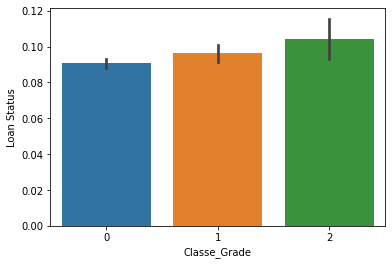

In [ ]:
# As we did with the Batch Enrolled, let's show the barplot.
sns.barplot(x='Classe_Grade', y='Loan Status', data =df)

- Sub Grade

In [ ]:
# We are going to do the same analysys with the feature Sub Grade.

In [ ]:
df['Sub Grade'].nunique()

35

In [ ]:
count_subgrade=df.groupby('Sub Grade').count().reset_index()[['Sub Grade', 'Loan Amount']]
sum_subgrade=df.groupby('Sub Grade').sum().reset_index()[['Sub Grade', 'Loan Status']]
countsum_subgrade=pd.merge(count_subgrade,sum_subgrade, how='inner',on='Sub Grade')
countsum_subgrade['subgradepercent']=countsum_subgrade['Loan Status']/countsum_subgrade['Loan Amount']

In [ ]:
# Looking at the DF below, we can't assume that there is a correlation between the Sub Grade and the Loan Status.
countsum_subgrade[['Sub Grade', 'subgradepercent']]

,Sub Grade,subgradepercent
0,A1,0.091642
1,A2,0.097986
2,A3,0.094362
3,A4,0.091431
4,A5,0.094068
5,B1,0.099863
6,B2,0.088920
7,B3,0.082521
8,B4,0.091887
9,B5,0.095657


In [ ]:
#Since we have seen there is no obvious correlation between each Sub Grade and the Loan Status, let's analyze if the aggregation of each letter (A1-A5, B1-B5, for instance) has a correlation with he target.
countsum_subgrade['subgradepercent'].iloc[:5].sum(),countsum_subgrade['subgradepercent'].iloc[5:10].sum(),countsum_subgrade['subgradepercent'].iloc[10:15].sum(),countsum_subgrade['subgradepercent'].iloc[15:20].sum(),countsum_subgrade['subgradepercent'].iloc[20:25].sum(),countsum_subgrade['subgradepercent'].iloc[25:30].sum(),countsum_subgrade['subgradepercent'].iloc[30:35].sum()


(0.46948898504852765,
 0.4588486089603282,
 0.4562992201996209,
 0.47497226741238235,
 0.4617083826559751,
 0.47714988232104616,
 0.504175926505378)

As we can see above, we can't assume any kind of correlation between the feature Sub Grade and the Loan Status. 

Said that, at first I excluded the feature. Than I realized that if I used the label encoder I would improve the score.

In [ ]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
df['Sub Grade']=le.fit_transform(df['Sub Grade'])
test['Sub Grade']=le.transform(test['Sub Grade'])

- Employment Duration

Once the duration should be a numeric feature, I believe the variable name is wrong.

In [ ]:
df['Employment Duration'].value_counts()

MORTGAGE    36351
RENT        24150
OWN          6962
Name: Employment Duration, dtype: int64

In [ ]:

countsum_EmploymentDuration=df.copy()
countsum_EmploymentDuration['Contador']=1
countsum_EmploymentDuration=countsum_EmploymentDuration.groupby('Employment Duration').sum().reset_index()[['Employment Duration', 'Contador', 'Loan Status']]
countsum_EmploymentDuration['EmploymentDuration%']=countsum_EmploymentDuration['Loan Status']/countsum_EmploymentDuration['Contador']

In [ ]:
countsum_EmploymentDuration[['Employment Duration','EmploymentDuration%']]

,Employment Duration,EmploymentDuration%
0,MORTGAGE,0.088663
1,OWN,0.101551
2,RENT,0.095694


In [ ]:
#We are going to use the label encoder and see if the algorithm finds some pattern.
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
df['Classe_EmplymentDuration']=le.fit_transform(df['Employment Duration'])
test['Classe_EmplymentDuration']=le.transform(test['Employment Duration'])

In [ ]:
df.drop('Employment Duration', axis=1, inplace=True)
test.drop('Employment Duration', axis=1, inplace=True)

- Verification Status

In [ ]:
df['Verification Status'].value_counts() 

Source Verified    33036
Verified           18078
Not Verified       16349
Name: Verification Status, dtype: int64

In [ ]:
countsum_VerificationStatus=df.copy()
countsum_VerificationStatus['Contador']=1
countsum_VerificationStatus=countsum_VerificationStatus.groupby('Verification Status').sum().reset_index()[['Verification Status', 'Contador', 'Loan Status']]
countsum_VerificationStatus['VerificationStatus%']=countsum_VerificationStatus['Loan Status']/countsum_VerificationStatus['Contador']

In [ ]:
countsum_VerificationStatus[['Verification Status', 'VerificationStatus%']]

,Verification Status,VerificationStatus%
0,Not Verified,0.092116
1,Source Verified,0.093383
2,Verified,0.091271


In [ ]:
# The percentages are almost the same. That way, let's use the label encoder and see if we can find a pattern when running the model.

In [ ]:
le = preprocessing.LabelEncoder()
df['Classe_Verification Status']=le.fit_transform(df['Verification Status'])
test['Classe_Verification Status']=le.transform(test['Verification Status'])

In [ ]:
df.drop('Verification Status', axis=1, inplace=True)
test.drop('Verification Status', axis=1, inplace=True)

- Payment Plan

In [ ]:
df['Payment Plan'].unique(), test['Payment Plan'].unique()

(array(['n'], dtype=object), array(['n'], dtype=object))

In [ ]:
#As this feature only has one class, it won't bring any information to our model. We are going to exclude it.
df.drop('Payment Plan', axis=1,inplace=True)
test.drop('Payment Plan', axis=1,inplace=True)

- Loan Title

This variable is the one that has the most numer of classes, 109. I tried in another submission to make a preprocessing. I joined the classes that were the same but written in different ways, also joined synonyms classes, but the log loss metric got worse.

I think the reason this happened is that the test has exactly the same classes as the train. Probably if we had to deploy the model, new classes could appear and would be better to do a preprocessing, reducing the amount of classes, but in this case it was not useful.

In [ ]:
df['Loan Title'].unique()

array(['Debt Consolidation', 'Credit card refinancing',
       'DEBT CONSOLIDATION', 'Debt consolidation', 'Home Improvement',
       'Other', 'Major purchase', 'Medical expenses', 'personal',
       'Home improvement', 'Refinance Loan', 'Credit Cards',
       'Credit Card Refinance', 'Business', 'Consolidated',
       'debt consolidation', 'CC Refi', 'Consolidate', 'Freedom', 'Loan',
       'Credit Card Consolidation', 'Credit Card Paydown', 'Home buying',
       'Credit Card Payoff', 'debt consolidation loan',
       'Consolidation Loan', 'Credit Consolidation', 'payoff',
       'CC-Refinance', 'Debt Consolidation Loan', 'Car financing',
       'CC Refinance', 'Refinance', 'Credit Card consolidation',
       'Consolidation', 'Personal', 'Debt Reduction', 'consolidation',
       'Vacation', 'Payoff', 'Lending Club', 'debt loan', 'Green loan',
       'Credit payoff', 'Credit Card Refi', 'Credit Card', 'consolidate',
       'Medical', 'Moving and relocation', 'Credit Card Loan', 'Bathro

In [ ]:
df['Loan Title'].nunique(), test['Loan Title'].nunique()

(109, 109)

In [ ]:
#As we can assume in this cell and in the above, all the classes in train and test are the same.
df[df['Loan Title'].isin(test['Loan Title'].unique())]['Loan Title'].nunique()

109

In [ ]:
countsum_LoanTitle=df.copy()
countsum_LoanTitle['Contador']=1
countsum_LoanTitle=countsum_LoanTitle.groupby('Loan Title').sum().reset_index()[['Loan Title', 'Contador', 'Loan Status']]
countsum_LoanTitle['LoanTitle%']=countsum_LoanTitle['Loan Status']/countsum_LoanTitle['Contador']
countsum_LoanTitle.sort_values(by='LoanTitle%', ascending=True).head(60)

,Loan Title,Contador,Loan Status,LoanTitle%
108,vacation,10,0,0.000000
43,Debt Consolidation 2013,6,0,0.000000
50,Debt payoff,7,0,0.000000
26,Credit Card Paydown,9,0,0.000000
21,Credit,4,0,0.000000
72,Medical loan,9,0,0.000000
18,Consolidated,13,0,0.000000
80,Personal loan,5,0,0.000000
13,Car Loan,9,0,0.000000
12,CONSOLIDATION,9,0,0.000000


In [ ]:
#I am going to split in 4 classes.
countsum_LoanTitle['LoanTitle%'].describe() 

count    109.000000
mean       0.105381
std        0.078955
min        0.000000
25%        0.064516
50%        0.098563
75%        0.142857
max        0.500000
Name: LoanTitle%, dtype: float64

In [ ]:
countsum_LoanTitle['Classe_LoanTitle']=0
countsum_LoanTitle.loc[countsum_LoanTitle['LoanTitle%']<0.064516, 'Classe_LoanTitle']=0
countsum_LoanTitle.loc[(countsum_LoanTitle['LoanTitle%']>=0.064516)&(countsum_LoanTitle['LoanTitle%']<0.098563), 'Classe_LoanTitle']=1
countsum_LoanTitle.loc[(countsum_LoanTitle['LoanTitle%']>=0.098563)&(countsum_LoanTitle['LoanTitle%']<0.142857), 'Classe_LoanTitle']=2
countsum_LoanTitle.loc[countsum_LoanTitle['LoanTitle%']>=0.142857, 'Classe_LoanTitle']=3

In [ ]:
countsum_LoanTitle=countsum_LoanTitle[['Loan Title', 'Classe_LoanTitle']]

In [ ]:
df=pd.merge(df, countsum_LoanTitle, how='inner', on='Loan Title')
test=pd.merge(test, countsum_LoanTitle, how='left', on='Loan Title')

In [ ]:
df.drop('Loan Title', axis=1,inplace=True)
test.drop('Loan Title', axis=1,inplace=True)

- Initial List Status

In [ ]:
df['Initial List Status'].value_counts()

w    36299
f    31164
Name: Initial List Status, dtype: int64

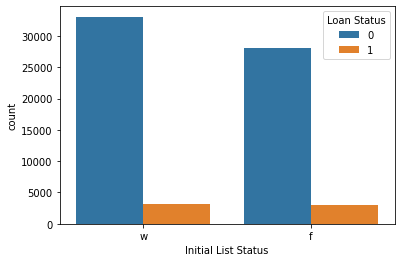

In [ ]:
# Let's visualize the proportion of the classes
sns.countplot(df['Initial List Status'], hue=df['Loan Status'])

In [ ]:
# We are going to do a label encoder
le = preprocessing.LabelEncoder()
df['Classe_Initial List Status']=le.fit_transform(df['Initial List Status'])
test['Classe_Initial List Status']=le.transform(test['Initial List Status'])

In [ ]:
df.drop('Initial List Status', axis=1, inplace=True)
test.drop('Initial List Status', axis=1, inplace=True)

- Application Type

As we can see, this features has only 2 classes, JOINT and INDIVIDUAL. In train dataset there are 67340 rows with Individual and only 123 with JOINT.

Besides, the proportion of 1s and 0s in each class are almost the same. We can conclude that this feature won't bring any information to our model, is irrelevant, so we are going to drop it.

In [ ]:
df['Application Type'].unique()

array(['INDIVIDUAL', 'JOINT'], dtype=object)

In [ ]:
len(df.loc[df['Application Type']=='INDIVIDUAL', 'Application Type'])

67340

In [ ]:
df.loc[df['Application Type']=='JOINT','Loan Status'].value_counts(), 11/112

(0    112
 1     11
 Name: Loan Status, dtype: int64, 0.09821428571428571)

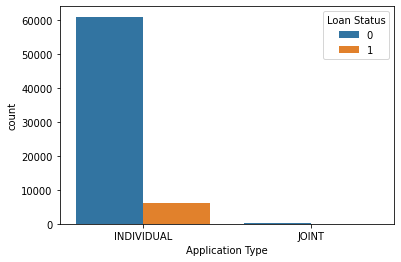

In [ ]:
# Let's visualize the proportion of the classes and notice how irrelevant for the dataset is this feature.
sns.countplot(df['Application Type'], hue=df['Loan Status'])

In [ ]:

df.drop('Application Type', axis=1, inplace=True)
test.drop('Application Type', axis=1, inplace=True)

Now that all the features are numeric, let's take a look at the correlation of pearson of the features in relation to the target.

We can see that the most correlated features are the ones that were engeneered.

In [ ]:
df.corr()['Loan Status'].sort_values(ascending=False) 

Loan Status                     1.000000
Classe_LoanTitle                0.034949
Classe_Batch_Enrolled           0.022428
Classe_EmplymentDuration        0.011927
Classe_Grade                    0.011417
Public Record                   0.010590
Delinquency - two years         0.009990
Total Current Balance           0.009828
Total Received Late Fee         0.009365
Total Collection Amount         0.007892
Last week Pay                   0.006117
Revolving Utilities             0.004120
Home Ownership                  0.003716
Sub Grade                       0.003675
Interest Rate                   0.002900
Total Received Interest         0.001680
Total Revolving Credit Limit    0.001454
Funded Amount                   0.001364
Inquires - six months           0.000578
Total Accounts                  0.000222
Funded Amount Investor         -0.000091
Recoveries                     -0.000652
Collection 12 months Medical   -0.000686
Revolving Balance              -0.001073
Classe_Verificat

Note that the correlation of Accounts Delinquent with Loan Status brought a NaN. That is because Accounts Delinquent only has 0s. We are going to exclude this feature.

In [ ]:
df['Accounts Delinquent'].value_counts()

0    67463
Name: Accounts Delinquent, dtype: int64

In [ ]:

df.drop('Accounts Delinquent', axis=1, inplace=True)
test.drop('Accounts Delinquent', axis=1, inplace=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 67463 entries, 0 to 67462
Data columns (total 31 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Loan Amount                   67463 non-null  int64  
 1   Funded Amount                 67463 non-null  int64  
 2   Funded Amount Investor        67463 non-null  float64
 3   Term                          67463 non-null  int64  
 4   Interest Rate                 67463 non-null  float64
 5   Sub Grade                     67463 non-null  int64  
 6   Home Ownership                67463 non-null  float64
 7   Debit to Income               67463 non-null  float64
 8   Delinquency - two years       67463 non-null  int64  
 9   Inquires - six months         67463 non-null  int64  
 10  Open Account                  67463 non-null  int64  
 11  Public Record                 67463 non-null  int64  
 12  Revolving Balance             67463 non-null  int64  
 13  R

Before finishing our analysis, is useful to take a look at Pandas Profiling.

In [ ]:

## Pandas Profiling 
!pip install pandas-profiling==2.8.0

from pandas_profiling import ProfileReport

profile = ProfileReport(df, title='Análise Exploratória dos Dados', html={'style':{'full_width':True}}) 

profile.to_notebook_iframe()

profile.to_file(output_file="Análise_Exploratória_dos_Dados.html")


'\n## Pandas Profiling \n!pip install pandas-profiling==2.8.0\n\nfrom pandas_profiling import ProfileReport\n\nprofile = ProfileReport(df, title=\'Análise Exploratória dos Dados\', html={\'style\':{\'full_width\':True}}) \n\nprofile.to_notebook_iframe()\n\nprofile.to_file(output_file="Análise_Exploratória_dos_Dados.html")\n'

We finished our feature analysis with 30 explanatory variables. Must be highlighted that our model will be a tree based model, so the presence of multicollinearity tend to 0. Thats's why I didn't analize the correlations between the explanatory variables, neither did a big work in feature selection.



Let's make the data sampling.

In [ ]:
# Spliting the explanatory variables from the target.
y=df['Loan Status']
x=df.drop('Loan Status', axis=1)
test.drop('Loan Status', axis=1, inplace=True)

In [93]:
# Spliting the data in training and validation set. As we are going to work with a tree based model, it won't be necessary to standardizate/ normalize de data
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, stratify=y, random_state=50) 

Now we are going to oversample our data and explain the reason why the sampling_strategy chosen was 0.11.

Before using the smote, the mean of the probability that the model brought was something between 9.5~10.5. However, from the feedback gived from the public leaderborad, using the Log Loss metric, and using the mean of my submission, I could calculate the mean of the public leaderboard.

The mean calculated was 11.3~12.0, in a way that my solution was a little bit displaced. The sampling_strategy of 0.11 was the value that shifted the mean of my submission to the proper range.



In [94]:
# When I submmited, I didn't defined a random_state.
from imblearn.over_sampling import SMOTE
oversample = SMOTE(sampling_strategy=0.11, random_state= 0)
x_train, y_train = oversample.fit_resample(x_train, y_train)
x_train=pd.DataFrame(x_train)


Obs: To test my theory, I made a submission to achieve the Dumb-Log Loss, using only the value I assumed to be the proportion of Loan defaulters, that is 0.1167. Before submitting, I calculated what would be the Log Loss of a submission that only contained the value of 0.1167, and got 0.3603. This solution (Sub 9) brought me a Log Loss of 0.36024, confirming my theory.


# Creating and Training the Model

The model should be a classifier model and for that I tried several models, for instance:

- RandomForestClassifier
- KneighborsClassifier
- Logistic Regression
- XGBClassifier
...

In additional, I tried to use VotingClassifier with combinations of the models above.

After trying all this models, the one that brought the best result in the Leaderboard was the RandomForestClassifier.




Using GridSearchCV for Hiperparameter Tuning.

In [80]:

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
cv = StratifiedKFold(n_splits = 5, shuffle = True)
param_grid = {'max_depth': [3,4,5], 'max_features': ['int','float','auto','log2']} 
modelgrid= GridSearchCV(RandomForestClassifier(),param_grid,refit=True,verbose=3, cv=cv, scoring='neg_log_loss')
modelgrid.fit(x_train,y_train)


Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END .......max_depth=3, max_features=int;, score=nan total time=   0.5s
[CV 2/5] END .......max_depth=3, max_features=int;, score=nan total time=   0.3s
[CV 3/5] END .......max_depth=3, max_features=int;, score=nan total time=   0.1s
[CV 4/5] END .......max_depth=3, max_features=int;, score=nan total time=   0.2s
[CV 5/5] END .......max_depth=3, max_features=int;, score=nan total time=   0.5s
[CV 1/5] END .....max_depth=3, max_features=float;, score=nan total time=   0.4s
[CV 2/5] END .....max_depth=3, max_features=float;, score=nan total time=   0.2s
[CV 3/5] END .....max_depth=3, max_features=float;, score=nan total time=   0.1s
[CV 4/5] END .....max_depth=3, max_features=float;, score=nan total time=   0.1s
[CV 5/5] END .....max_depth=3, max_features=float;, score=nan total time=   0.2s
[CV 1/5] END ...max_depth=3, max_features=auto;, score=-0.322 total time=   6.3s
[CV 2/5] END ...max_depth=3, max_features=auto;,

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
             estimator=RandomForestClassifier(),
             param_grid={'max_depth': [3, 4, 5],
                         'max_features': ['int', 'float', 'auto', 'log2']},
             scoring='neg_log_loss', verbose=3)

In [81]:
# These are the best params according to GrindSearch.
modelgrid.best_params_ 

{'max_depth': 5, 'max_features': 'auto'}

In [95]:
# Instantiating the model and fitting with train data.

from sklearn.ensemble import RandomForestClassifier
model=RandomForestClassifier(max_depth=5, random_state=4)
model.fit(x_train,y_train)

RandomForestClassifier(max_depth=5, random_state=4)

# Model Evaluation (Log Loss Metric)

In [96]:
#Predicting the probabilities for the train and validation dataset. Analizing both is good to see the degree of overfitting we have in the model.
predicttrain=model.predict_proba(x_train)
predictval=model.predict_proba(x_val)

In [97]:
# Importing the library containing the metric that will be used to evaluate the submission.
from sklearn.metrics import log_loss  
log_loss(y_train, predicttrain), log_loss(y_val, predictval)


(0.31869819806696115, 0.30796569357732495)

We have already calculated the Log Loss Metric, but in a way that our validation become more robust, is advisable that we use cross validation.

As we had two transformers after sampling the data, we can use a pipeline. One of the transformers is a SMOTE oversample, so I will use the Pipeline from the imblearn library instead of the SKLearn one.

In [98]:

from imblearn.pipeline import Pipeline as imbpipeline
pipe = imbpipeline([('oversample', oversample) ,('RF', model)])

In [99]:

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
cv = StratifiedKFold(n_splits = 5, shuffle = True)
scores=cross_val_score(pipe, x,y, cv = cv, scoring='neg_log_loss')
scores, np.mean(scores)


(array([-0.30787765, -0.30798759, -0.30815773, -0.30815614, -0.30797908]),
 -0.30803163939527917)

# Making the Submission

In [100]:
# Predicting the probabilities
predict=model.predict_proba(test)

In [101]:
predict

array([[0.89884045, 0.10115955],
       [0.91394415, 0.08605585],
       [0.90029674, 0.09970326],
       ...,
       [0.83151657, 0.16848343],
       [0.83772895, 0.16227105],
       [0.8304448 , 0.1695552 ]])

In [102]:
final=pd.DataFrame(predict)
final=pd.DataFrame(final[1])
final.columns=['Loan Status']
final['Loan Status']=round(final['Loan Status'],6) 
final

,Loan Status
0,0.101160
1,0.086056
2,0.099703
3,0.095463
4,0.094190
...,...
28908,0.232307
28909,0.181581
28910,0.168483
28911,0.162271


In [104]:
final.to_csv('Felipe_Carneiro_Wanderley_submission.csv', index=False)

Note: The prediction generated from this notebook can be a little bit different from Sub27, my winner solution. The only difference is that I havent't defined a random_state for Smote when I submmited the code.